In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import hiddenlayer as hl

In [2]:
from glob import glob

train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

train_files[0]

'./fashion-mnist/train/4/12221.png'

In [3]:
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(55000, 10000, 5000)

In [4]:
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
    Y_train.append( int(train_file.split('/')[3]) )
    X_train.append(np.array(Image.open(train_file)))

In [5]:
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
    Y_valid.append( int(valid_file.split('/')[3]) )
    X_valid.append( np.array(Image.open(valid_file)) )

In [6]:
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
    Y_test.append( int(test_file.split('/')[3]) )
    X_test.append( np.array(Image.open(test_file)) )

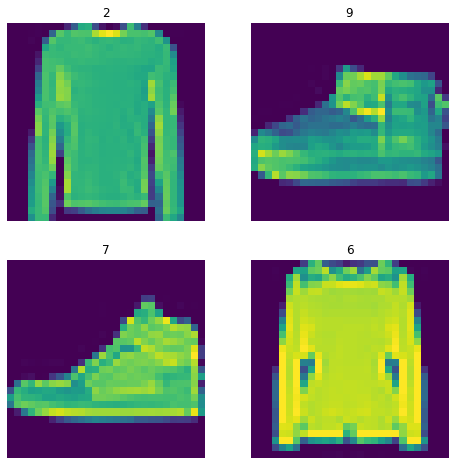

In [7]:
fig = plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(X_test[i*15])
    plt.title(Y_test[i*15])
    plt.axis(False)
plt.show()

In [8]:
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([55000, 28, 28])

In [9]:
batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [10]:
model = torch.nn.Sequential(
    # in: 28 * 28 * 1
    torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
    # out: (28-5+4)/1 + 1 = 28   -> 28*28*16
    
    torch.nn.ReLU(),
    
    torch.nn.AvgPool2d(kernel_size=2),
    # 28/2 = 14    -> 14*14*16
    
    torch.nn.Dropout(p=0.2),
    
    
    torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
    # (28-5+4)/1 + 1 = 14   -> 14*14*64
    
    torch.nn.ReLU(),
    
    torch.nn.AvgPool2d(kernel_size=2),
    # 14/2 = 7    -> 7*7*32
    
    torch.nn.Dropout(p=0.2),
    
    torch.nn.Flatten(),
    
    torch.nn.Linear(7*7*32, 10)
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Dropout(p=0.2, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1568, out_features=10, bias=True)
)

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)

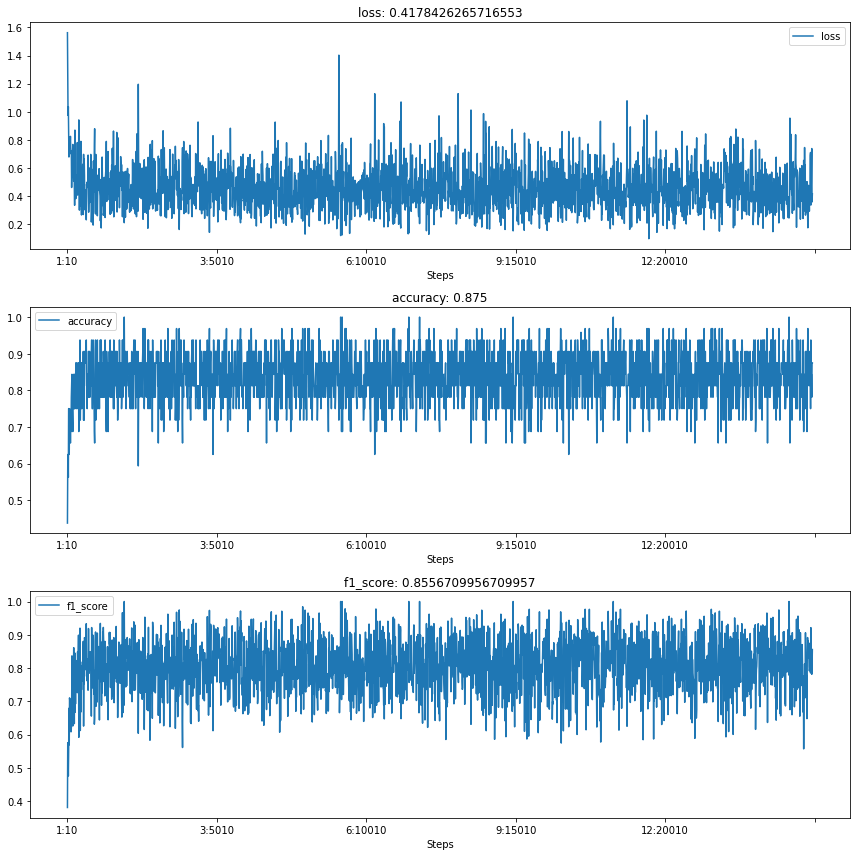

In [ ]:

from sklearn.metrics import f1_score

n_epoch = 15

history = hl.History()
canvas = hl.Canvas()

iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    model.train()
    #print(X_train_batch.size())
    Xtr = X_train_batch.unsqueeze(1)
    #print(Xtr.size())
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)
    f1 = f1_score(Y_train_batch, Y_pred, average='macro')    

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%10 == 0:
        #-- Visualizamos la evolución de los score loss y accuracy
        history.log((epoch+1, iter), loss=loss, accuracy=acc, f1_score=f1)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["accuracy"])
          canvas.draw_plot(history['f1_score'])

En esta CNN definimos dos capas convolucionales con una capa lineal y 10 caracteristicas, para la cual se llega a obtener un valor de 0.9375 para el accuracy, con un valor del 0.23 de loss y 0.86 para f1_score